### Project Setup

In [2117]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Citirea setului de date

In [2118]:
# Citirea setului de date
df = pd.read_csv('dataset.csv')

### Filtrarea datelor

In [2119]:
# Eliminam din dataset NaN si +- Inifity
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [2120]:
# Inlocuiesc NaN si +- Infinity cu mediana pe coloane pentru
#df = df.replace([np.inf, -np.inf], np.nan)
#df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# 3.1. Explorarea Datelor (Exploratory Data Analysis)

## 1. Analiza Echilibrului de Clase

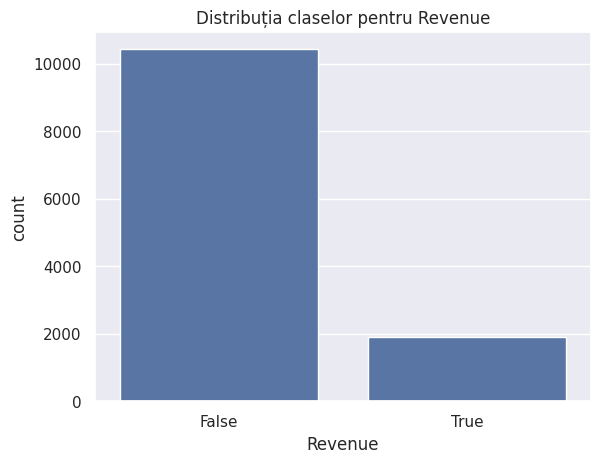

In [2121]:
# Verificarea echilibrului claselor
sns.countplot(x='Revenue', data=df)
plt.title('Distribuția claselor pentru Revenue')
plt.show()

## 2. Vizualizarea Atributelor

### 2.A Atribute Numerice

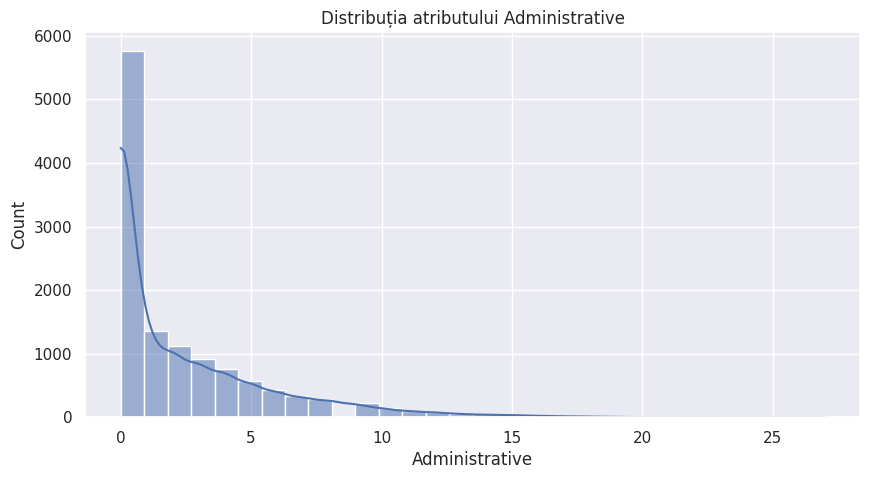

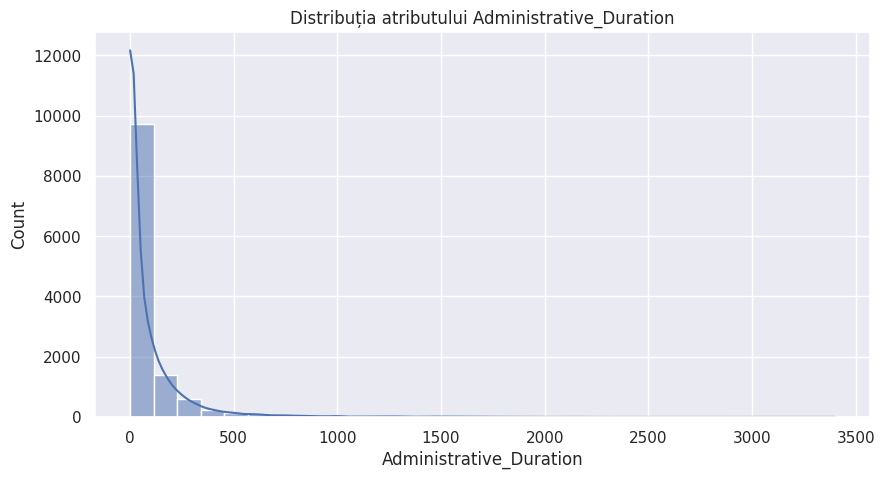

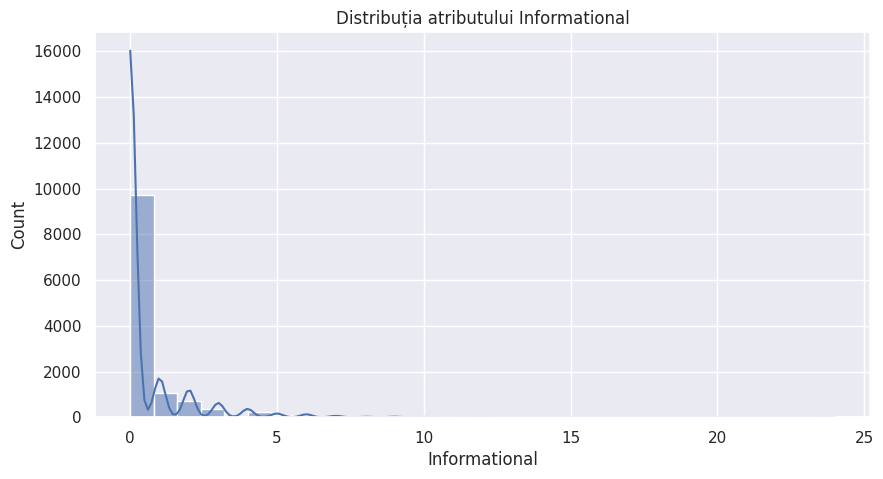

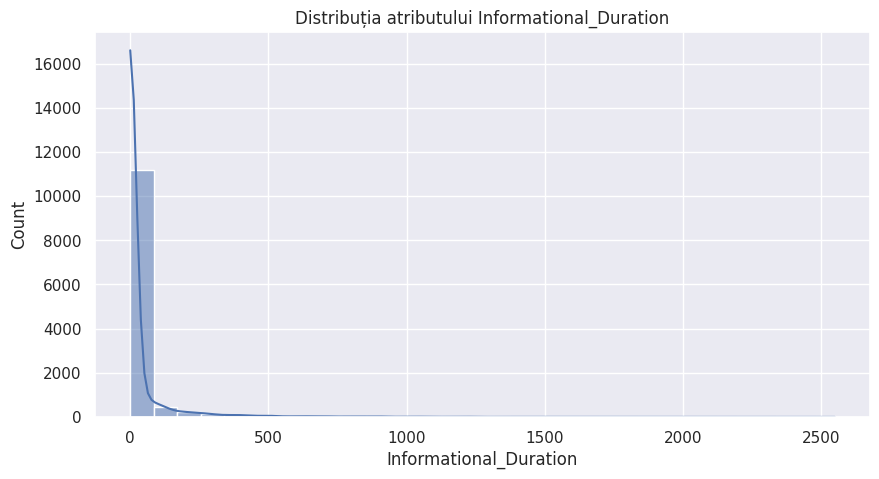

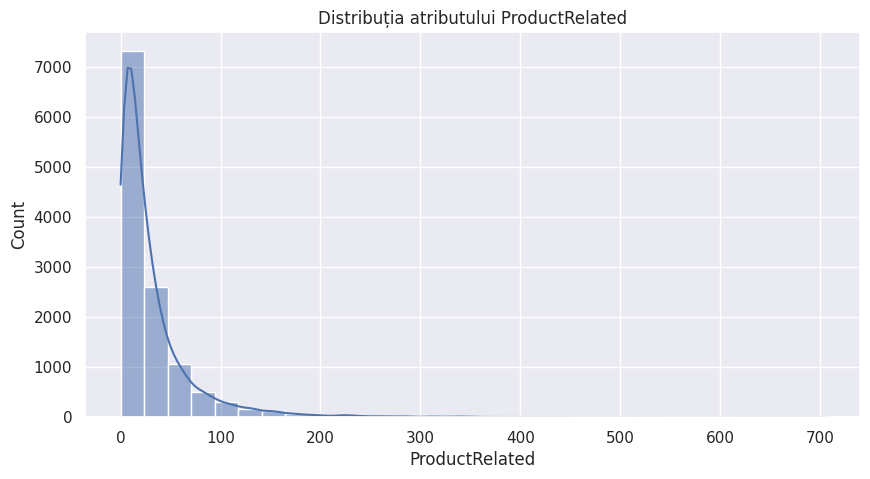

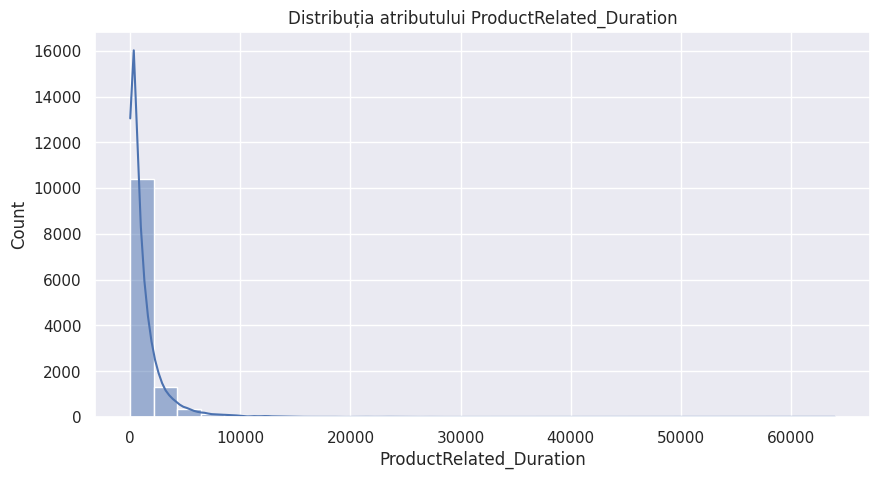

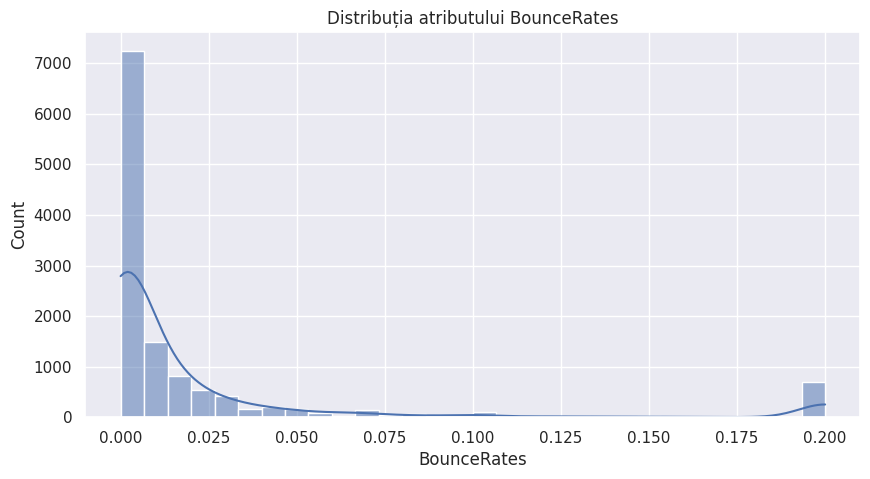

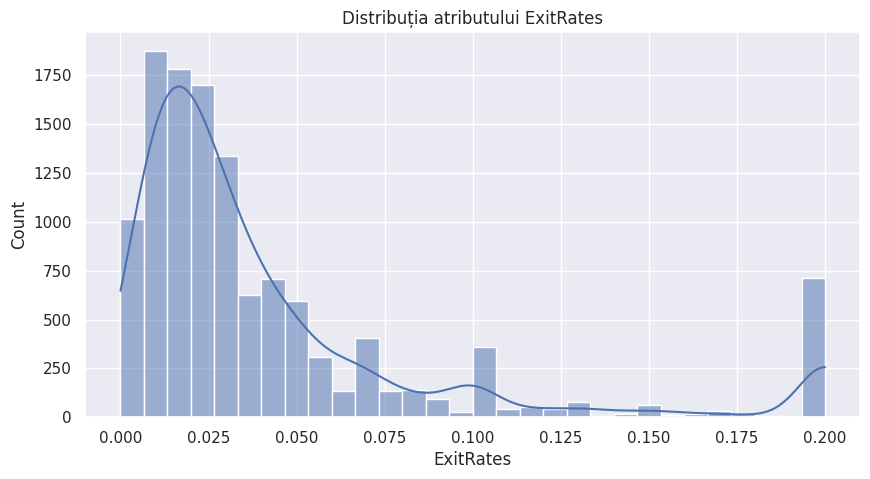

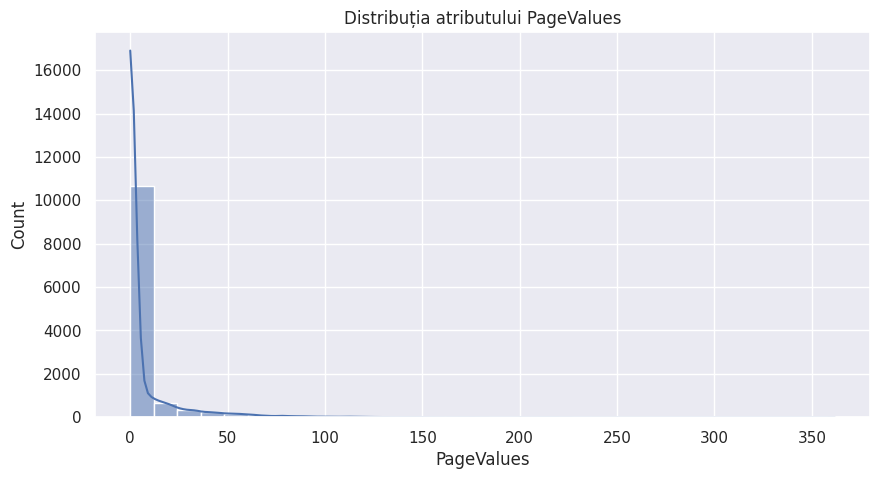

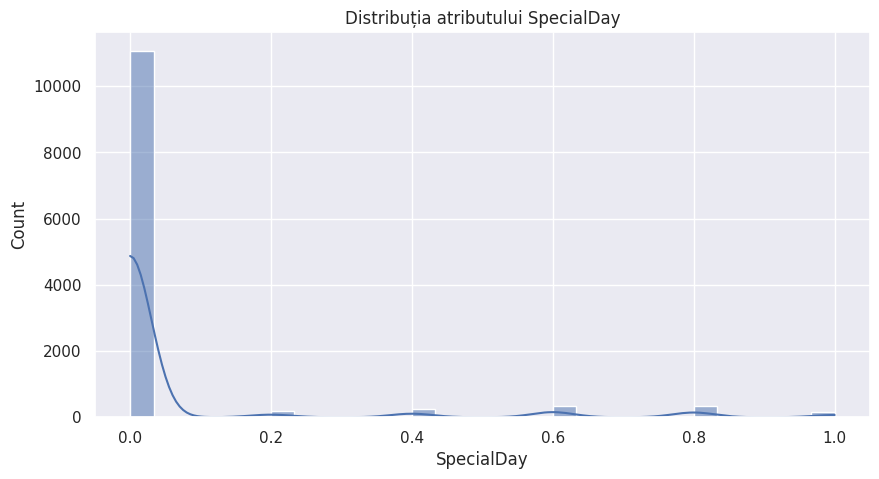

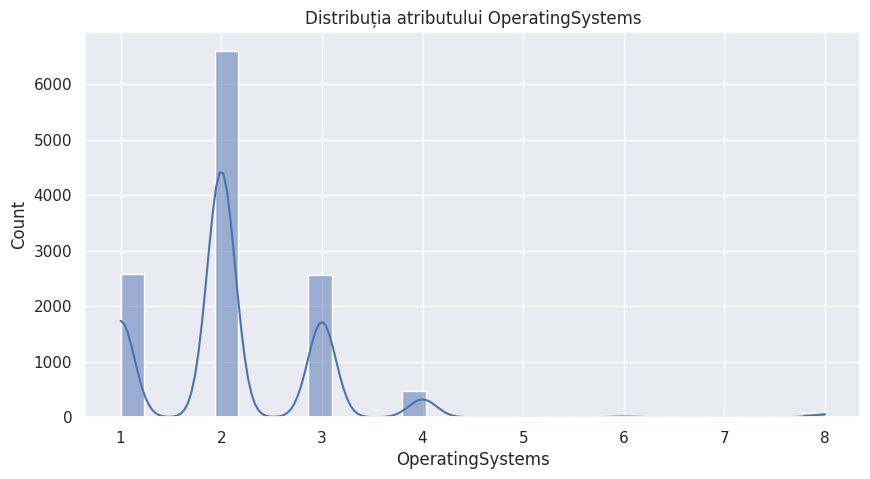

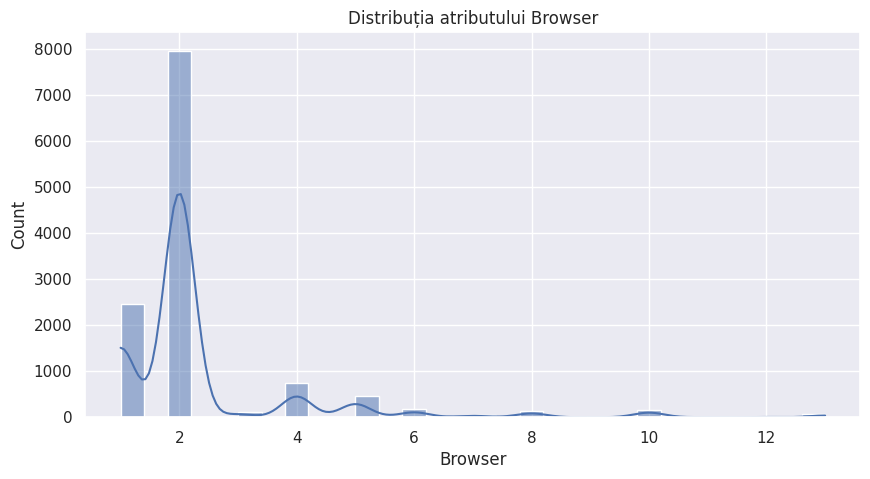

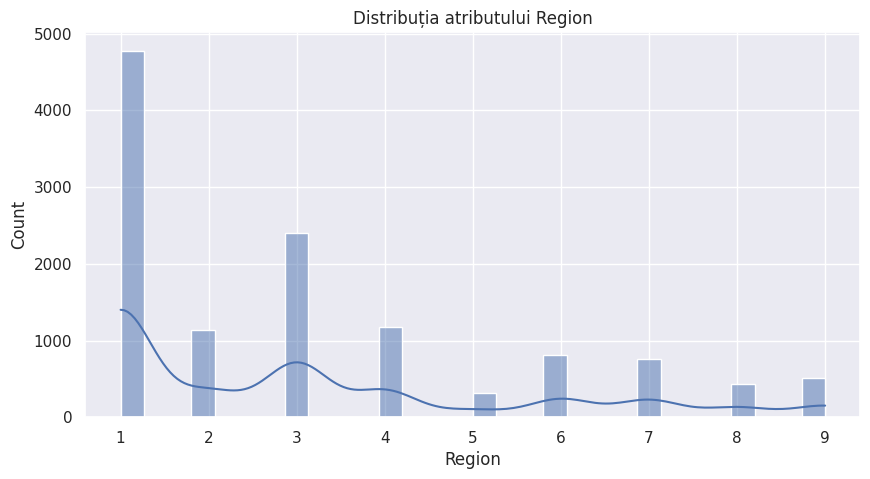

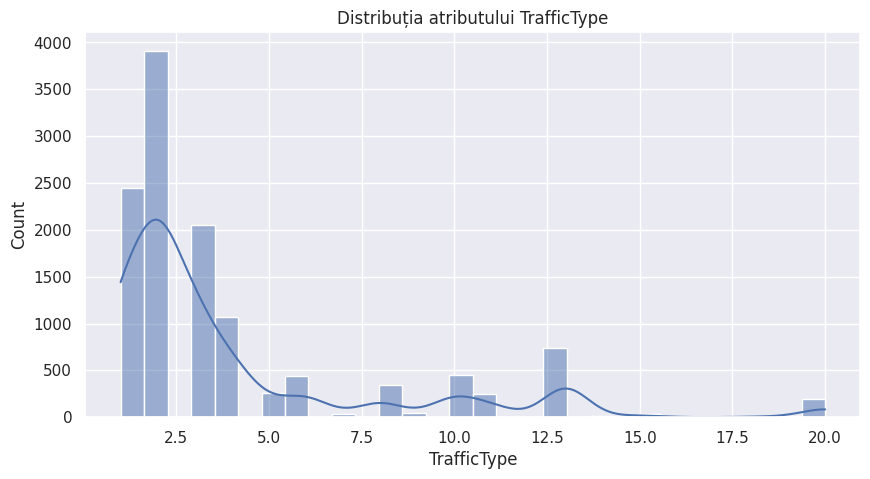

In [2122]:
# Identificarea atributelor numerice
numeric_attributes = df.select_dtypes(include=np.number).columns.tolist()

# Vizualizare distribuție pentru atribute numerice
for attribute in numeric_attributes:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[attribute], bins=30, kde=True)
    plt.title(f'Distribuția atributului {attribute}')
    plt.show()

### 2.A Atribute Categorice

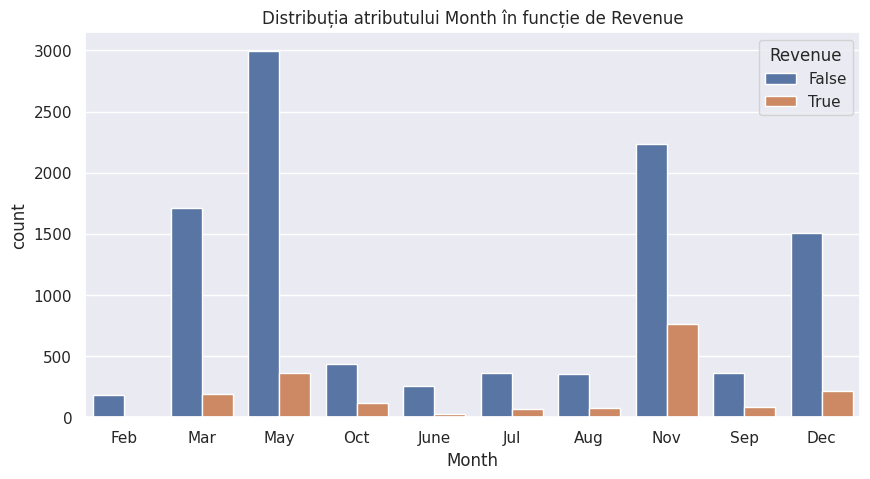

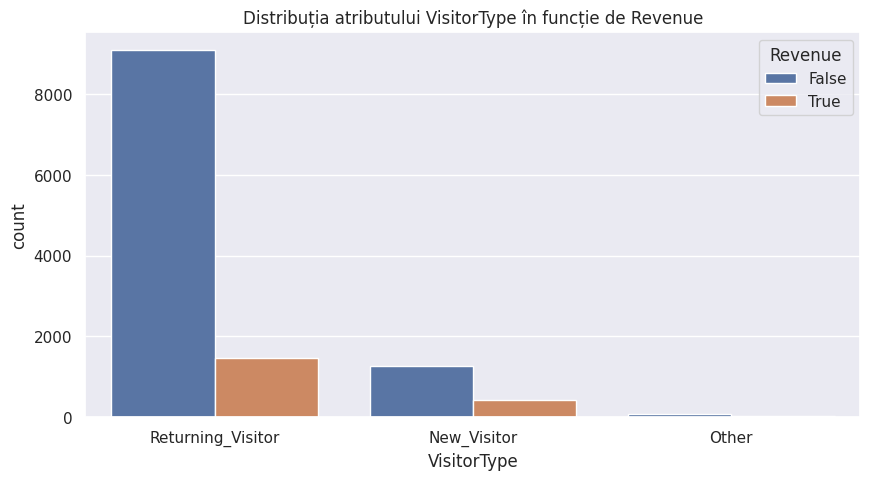

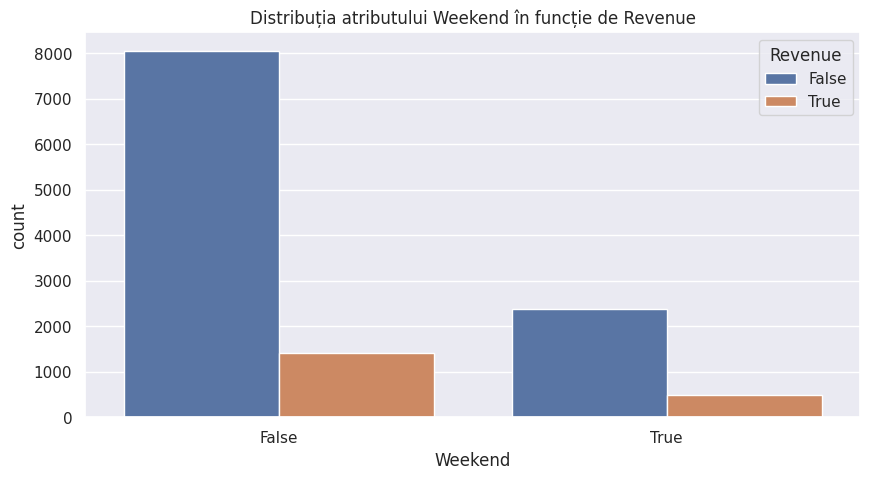

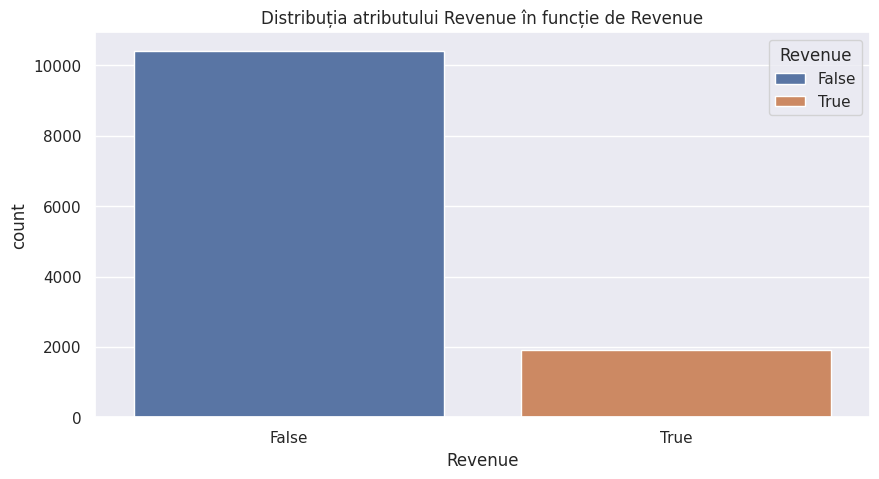

In [2123]:
# Identificarea atributelor categorice
categorical_attributes = df.select_dtypes(exclude=np.number).columns.tolist()

# Vizualizare distribuție pentru atribute categorice
for attribute in categorical_attributes:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=attribute, data=df, hue='Revenue')
    plt.title(f'Distribuția atributului {attribute} în funcție de Revenue')
    plt.show()


## 3. Analiza Gradului de Corelare

### 3.A Atribute Numerice cu Coeficientul de Point-Biserial

                  Attribute  Correlation        P-Value
0            Administrative     0.138917   3.519760e-54
1   Administrative_Duration     0.093587   2.146514e-25
2             Informational     0.095200   3.174034e-26
3    Informational_Duration     0.070345   5.282871e-15
4            ProductRelated     0.158538   3.241187e-70
5   ProductRelated_Duration     0.152373   6.115338e-65
6               BounceRates    -0.150673   1.594198e-63
7                 ExitRates    -0.207071  1.662654e-119
8                PageValues     0.492569   0.000000e+00
9                SpecialDay    -0.082305   5.498934e-20
10         OperatingSystems    -0.014668   1.033943e-01
11                  Browser     0.023984   7.736888e-03
12                   Region    -0.011595   1.979426e-01
13              TrafficType    -0.005113   5.702434e-01




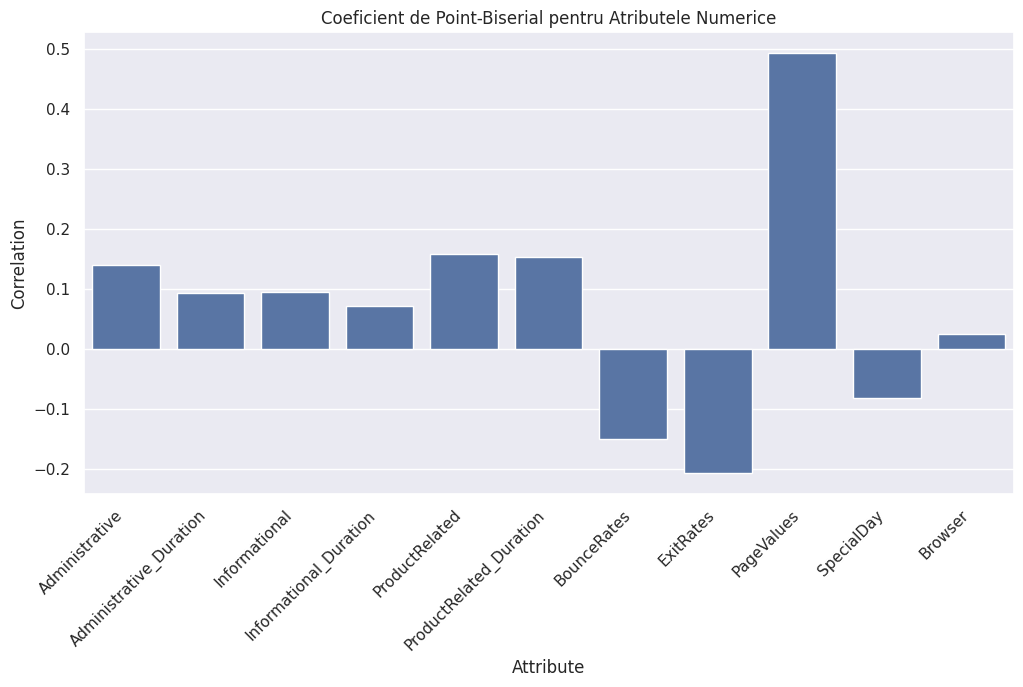

In [2124]:
correlation_results_numeric = []

for attribute in numeric_attributes:
    if attribute != 'Revenue':
        correlation, p_value = pointbiserialr(df[attribute], df['Revenue'])
        correlation_results_numeric.append({'Attribute': attribute, 'Correlation': correlation, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_numeric = pd.DataFrame(correlation_results_numeric)
print(correlation_df_numeric)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_numeric_attributes = correlation_df_numeric[correlation_df_numeric['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Attribute', y='Correlation', data=significant_numeric_attributes)
plt.title('Coeficient de Point-Biserial pentru Atributele Numerice')

# Rotirea etichetelor pe axa X pentru a face vizualizarea mai lizibilă
X_fields = significant_numeric_attributes['Attribute'].tolist()
barplot.set_xticks(range(len(X_fields)))
barplot.set_xticklabels(X_fields, rotation=45, horizontalalignment='right')

plt.show()

### 3.B Atribute Categorice cu Testul Chi-squared

     Attribute   Chi-squared       P-Value
0        Month    384.934762  2.238786e-77
1  VisitorType    135.251923  4.269904e-30
2      Weekend     10.390978  1.266325e-03
3      Revenue  12322.355847  0.000000e+00




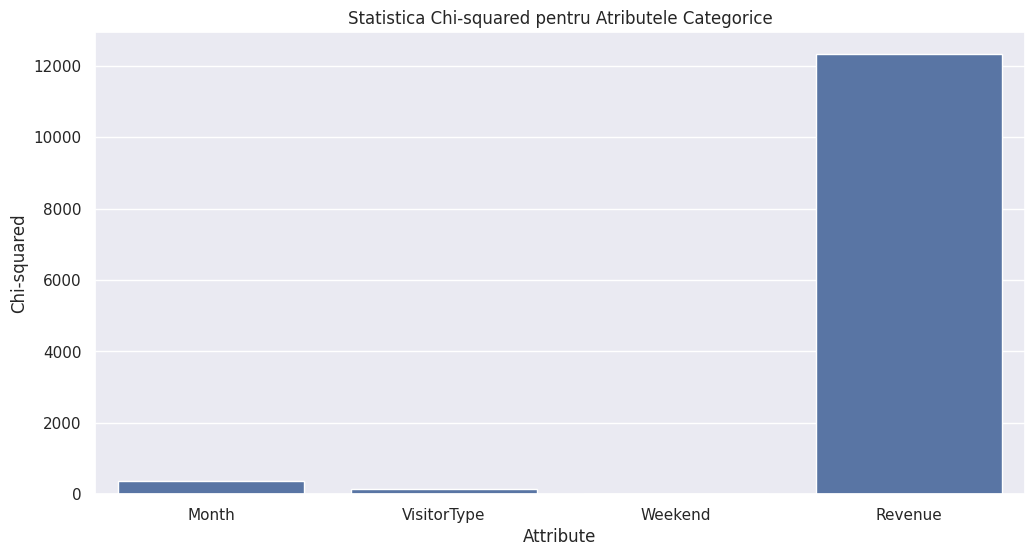

In [2125]:
correlation_results_categorical = []

for attribute in categorical_attributes:
    contingency_table = pd.crosstab(df[attribute], df['Revenue'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    correlation_results_categorical.append({'Attribute': attribute, 'Chi-squared': chi2, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_categorical = pd.DataFrame(correlation_results_categorical)
print(correlation_df_categorical)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_categorical_attributes = correlation_df_categorical[correlation_df_categorical['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
sns.barplot(x='Attribute', y='Chi-squared', data=significant_categorical_attributes)
plt.title('Statistica Chi-squared pentru Atributele Categorice')
plt.show()


# 3.2. Antrenarea și Evaluarea Algoritmilor de Predicție

#### Setting some variables needed for the comparison

In [2126]:
# Plot X axis step
STEP_PERCENT=1.25
# Number of times to run the function
num_iterations = 10

## 3.2.1. Regresie Logistică

### 1. Implementare manuală

#### Regresia Logistica

In [2127]:
clipped_value = 500

def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train, :], X[N_train:, :]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test

def logistic(x):
    # Clip the input values to prevent overflow
    clipped_x = np.clip(x, -clipped_value, clipped_value)
    
    # Calculate the logistic function on the clipped values
    return 1 / (1 + np.exp(-clipped_x))

# Negative Log Likelihood - functia J(w)
def nll(Y, T):
    epsilon = 1e-15
    Y = np.clip(Y, epsilon, 1 - epsilon)
    return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

def accuracy(Y, T):
    predicted_labels = np.round(Y)
    correct_predictions = np.sum(predicted_labels == T)
    total_samples = len(T)
    return correct_predictions / total_samples

# Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
def train_logistic(X, T, lr=0.01, epochs_no=100):
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn(D + 1)

    for epoch in range(epochs_no):
        Y = logistic(np.dot(X_hat, W))
        gradient = np.dot(X_hat.T, (Y - T))
        W -= lr * gradient

    return W

# Calculati predictia Y a modelului logistic antrenat (ponderile W invatate)
def predict_logistic(X, W):
    X_hat = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

def train_logistic_full(X, T, lr=0.01, learning_increase_percent=2.5, epochs_no=1000):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn(D + 1)

    X_train, T_train, X_test, T_test = split_dataset(X1, T)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        # Maresc learning rate-ul pt fiecare epoch
        lr = lr * (1 + learning_increase_percent / 100) 
        
        Y_train = logistic(X_train @ W)
        
        gradient = np.transpose(X_train) @ (Y_train-T_train)/N
        W -= lr * gradient

        logits = np.dot(X_test, W)
        Y_test = 1. / (1. + np.exp(-np.clip(logits, -clipped_value, clipped_value)))

        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())

    return W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Preprocesarea datelor

In [2128]:
def preprocess_data(df):
    # Split set de date în caracteristici (X) și variabilă țintă (y)
    X = df.drop('Revenue', axis=1)
    y = df['Revenue'] # Revenue este boolean ( 0 / 1)
    
    # Conversia variabilelor categorice în formă numerică
    label_encoder = LabelEncoder()
    categorical_columns = ['Month', 'VisitorType', 'Weekend']
    for column in categorical_columns:
        X[column] = label_encoder.fit_transform(X[column])

    return X, y

#### Functie pentru plotting

In [2129]:
# Definim o functie ajutatoare pentru plotting
def plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent=2.5):
    # Step_percent = 5 <==> 100 / 5 == 20 X points on the plot
    epochs_no = len(train_acc)
    step = round(epochs_no * step_percent / 100)
    # If step is 0, we will set minimum default step for the plotting
    if step == 0:
        step = 1
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Plotting accuracy evolution
    ax1.plot(range(0, epochs_no, step), train_acc[::step], sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(0, epochs_no, step), test_acc[::step], sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Plotting negative log likelihood evolution
    ax2.plot(range(0, epochs_no, step), train_nll[::step], sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(0, epochs_no, step), test_nll[::step], sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)

    # Adding title with scaler information
    plt.suptitle(f'Evolution with Scaler: {scaler}')
    plt.show()
    
    return (ax1, ax2)

In [2130]:
# Function to print metrics for a specific measure (e.g., accuracy, precision, recall, f1_score)
def print_metrics(metric_name, results_dict, num_iterations):
    for scaler_name, metric_list in results_dict.items():
        mean_metric = np.mean(metric_list)
        median_metric = np.median(metric_list)
        variance_metric = np.var(metric_list)
        min_metric = np.min(metric_list)
        max_metric = np.max(metric_list)

        print(f"\nMetrics for {metric_name} with {scaler_name} after {num_iterations} runs:")
        print(f"Mean {metric_name}: {mean_metric}")
        print(f"Median {metric_name}: {median_metric}")
        print(f"Variance {metric_name}: {variance_metric}")
        print(f"Min {metric_name}: {min_metric}")
        print(f"Max {metric_name}: {max_metric}")

#### Datele de fitting ale modelului

In [2131]:
EPOCHS_NO = 200
LR = 0.035
LEARNING_INCREASE_PERCENT = 1

### Scalers

In [2132]:
# Normalizarea datelor (Scalare)
scalers = {
        'MinMaxScaler': MinMaxScaler(),
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler()
}

In [2133]:
def logistic_regression_manual(X, y, lr=0.01, learning_increase_percent=2.5, epochs_no=100, step_percent=100):
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)

        # Antrenarea modelului logistic
        W, train_acc, test_acc, train_nll, test_nll, W_trace = train_logistic_full(X_train_scaled, y_train, lr=lr, epochs_no=epochs_no)

        # Evaluarea modelului pe setul de testare
        X_test_scaled = scaler.transform(X_test)
        Y_test = predict_logistic(X_test_scaled, W)

        # Evaluare metrici pe setul de testare
        precision = precision_score(y_test, np.round(Y_test))
        recall = recall_score(y_test, np.round(Y_test))
        f1 = f1_score(y_test, np.round(Y_test))
        test_accuracy = accuracy(Y_test, y_test)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Vizualizare evolutie
        plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent)
        
        # Eliberare memorie
        del X_train, X_train_scaled, X_test_scaled, Y_test, W, train_acc, test_acc, train_nll, test_nll, W_trace

### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

Training dataset size: 12330
Number of features: 17

RULAREA NUMARUL 1
Acuratete folosind MinMaxScaler: 0.6021897810218978
Precision folosind MinMaxScaler: 0.06506364922206506
Recall folosind MinMaxScaler: 0.12568306010928962
F1 Score folosind MinMaxScaler: 0.08574091332712022


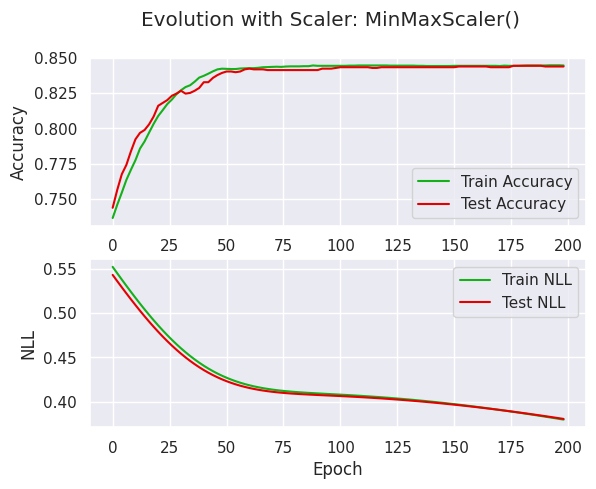

Acuratete folosind StandardScaler: 0.4257907542579075
Precision folosind StandardScaler: 0.12937812723373837
Recall folosind StandardScaler: 0.47757255936675463
F1 Score folosind StandardScaler: 0.20359955005624294


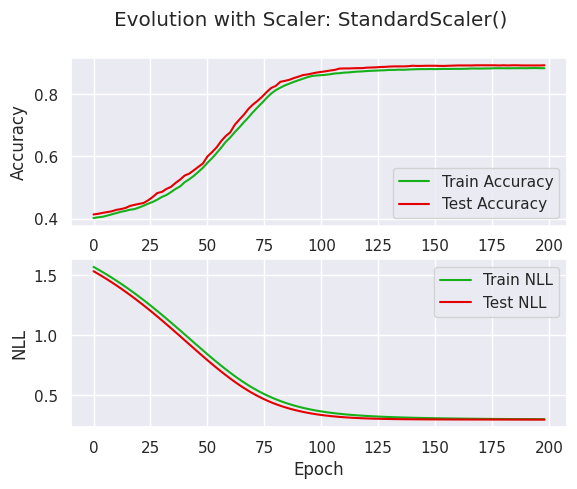

Acuratete folosind RobustScaler: 0.6261151662611517
Precision folosind RobustScaler: 0.03727714748784441
Recall folosind RobustScaler: 0.06552706552706553
F1 Score folosind RobustScaler: 0.04752066115702479


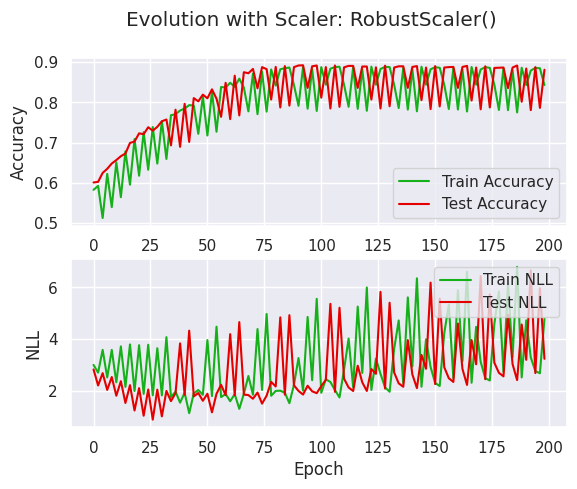


RULAREA NUMARUL 2
Acuratete folosind MinMaxScaler: 0.3126520681265207
Precision folosind MinMaxScaler: 0.16683518705763398
Recall folosind MinMaxScaler: 0.8753315649867374
F1 Score folosind MinMaxScaler: 0.2802547770700637


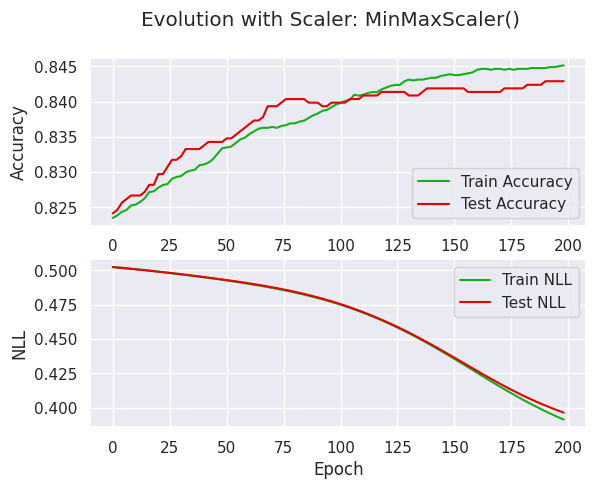

Acuratete folosind StandardScaler: 0.3410381184103812
Precision folosind StandardScaler: 0.07364074328974536
Recall folosind StandardScaler: 0.2772020725388601
F1 Score folosind StandardScaler: 0.11636759108210985


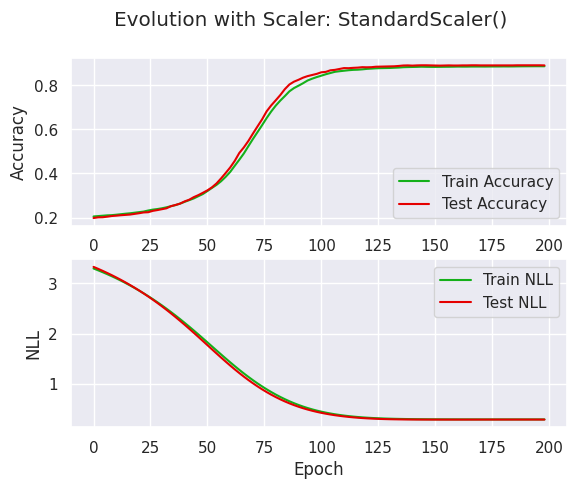

Acuratete folosind RobustScaler: 0.6374695863746959
Precision folosind RobustScaler: 0.14658925979680695
Recall folosind RobustScaler: 0.24815724815724816
F1 Score folosind RobustScaler: 0.1843065693430657


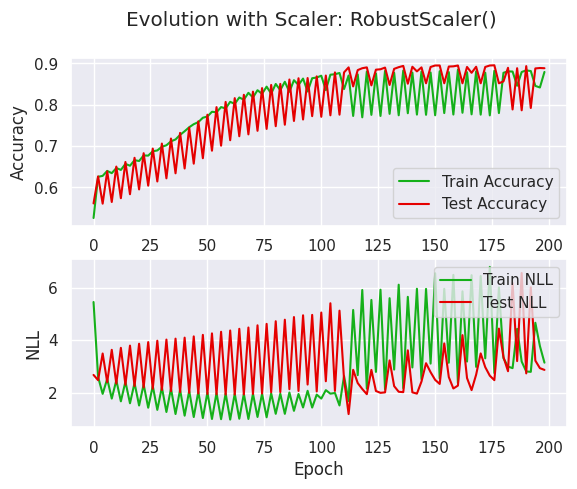


RULAREA NUMARUL 3
Acuratete folosind MinMaxScaler: 0.7331711273317113
Precision folosind MinMaxScaler: 0.10658307210031348
Recall folosind MinMaxScaler: 0.08353808353808354
F1 Score folosind MinMaxScaler: 0.09366391184573003


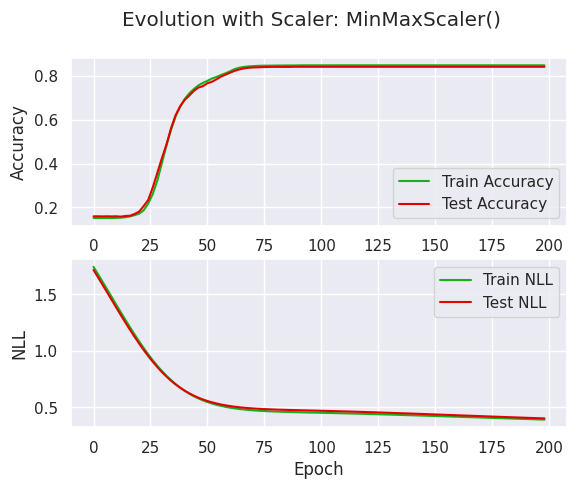

Acuratete folosind StandardScaler: 0.33779399837794
Precision folosind StandardScaler: 0.08788282290279627
Recall folosind StandardScaler: 0.3341772151898734
F1 Score folosind StandardScaler: 0.13916710595677384


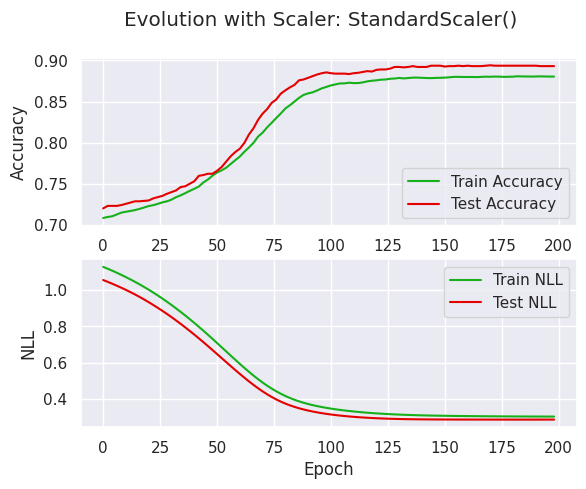

Acuratete folosind RobustScaler: 0.4643146796431468
Precision folosind RobustScaler: 0.012578616352201259
Recall folosind RobustScaler: 0.030690537084398978
F1 Score folosind RobustScaler: 0.01784386617100372


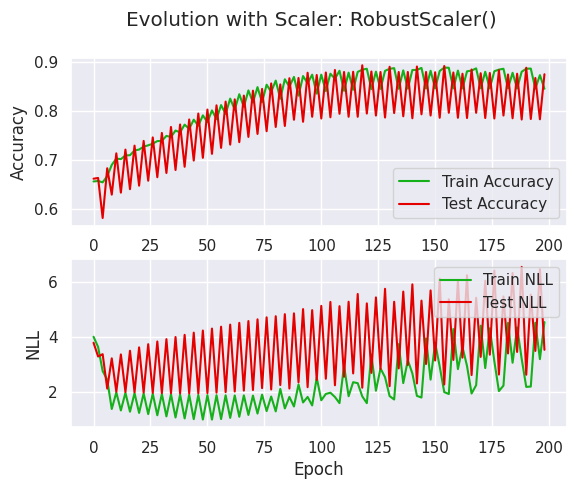


RULAREA NUMARUL 4
Acuratete folosind MinMaxScaler: 0.46715328467153283
Precision folosind MinMaxScaler: 0.11722488038277512
Recall folosind MinMaxScaler: 0.4152542372881356
F1 Score folosind MinMaxScaler: 0.1828358208955224


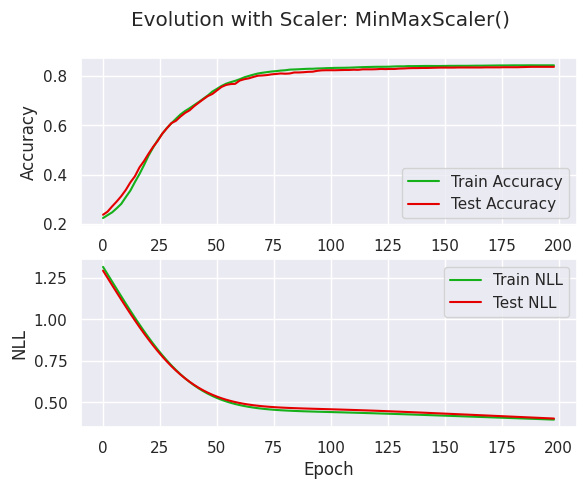

Acuratete folosind StandardScaler: 0.33211678832116787
Precision folosind StandardScaler: 0.05955678670360111
Recall folosind StandardScaler: 0.22933333333333333
F1 Score folosind StandardScaler: 0.09455744914788346


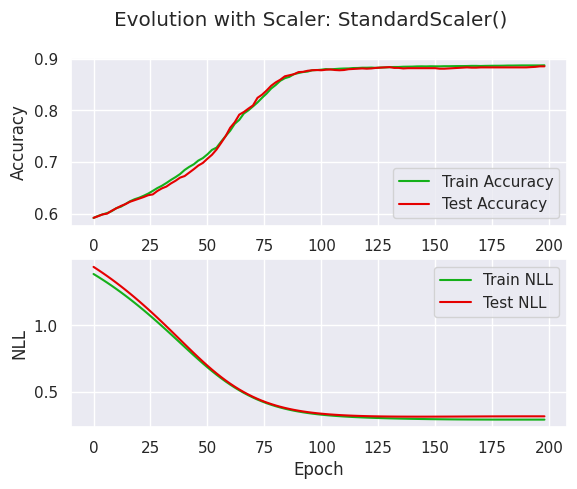

Acuratete folosind RobustScaler: 0.46147607461476076
Precision folosind RobustScaler: 0.02584493041749503
Recall folosind RobustScaler: 0.06951871657754011
F1 Score folosind RobustScaler: 0.03768115942028986


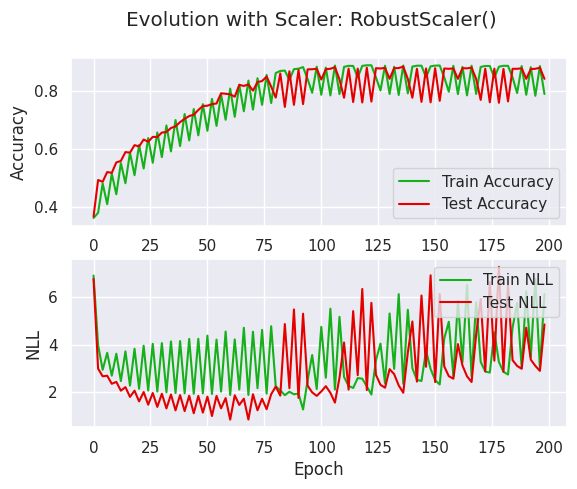


RULAREA NUMARUL 5
Acuratete folosind MinMaxScaler: 0.813463098134631
Precision folosind MinMaxScaler: 0.09210526315789473
Recall folosind MinMaxScaler: 0.017587939698492462
F1 Score folosind MinMaxScaler: 0.02953586497890295


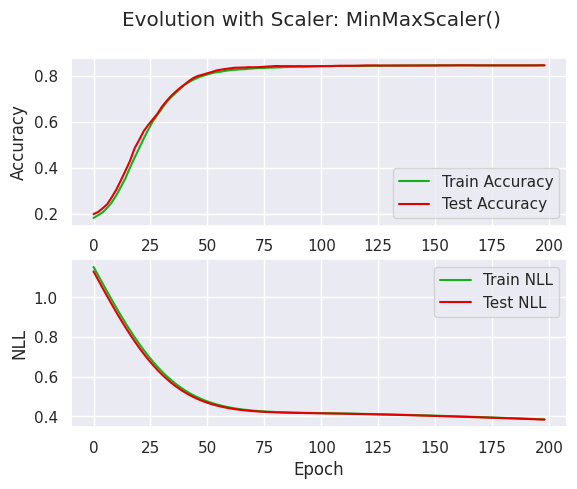

Acuratete folosind StandardScaler: 0.32725060827250607
Precision folosind StandardScaler: 0.06866077498300475
Recall folosind StandardScaler: 0.258974358974359
F1 Score folosind StandardScaler: 0.10854379365932293


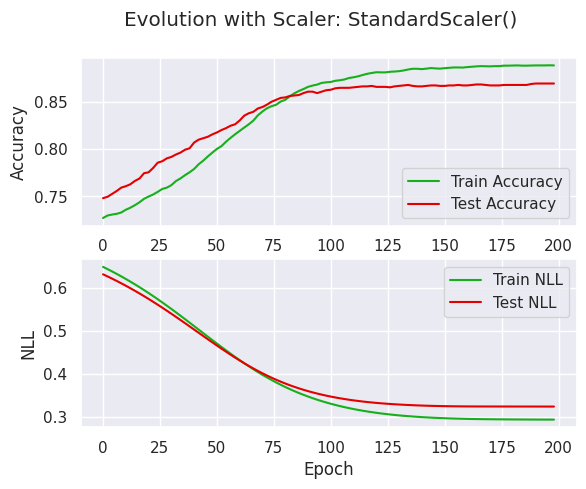

Acuratete folosind RobustScaler: 0.5218978102189781
Precision folosind RobustScaler: 0.08902691511387163
Recall folosind RobustScaler: 0.22337662337662337
F1 Score folosind RobustScaler: 0.12731310140636565


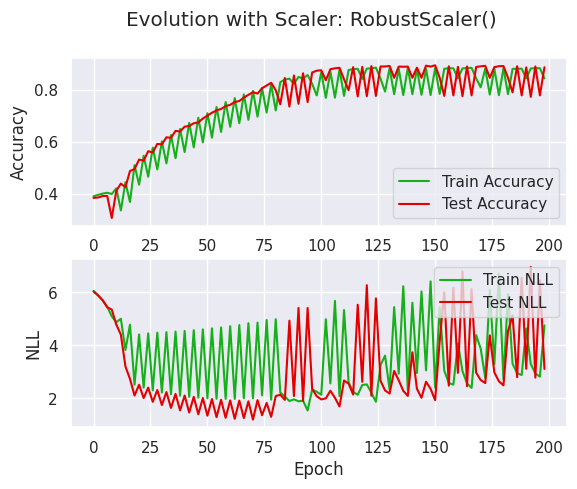


RULAREA NUMARUL 6
Acuratete folosind MinMaxScaler: 0.5697485806974858
Precision folosind MinMaxScaler: 0.10289017341040463
Recall folosind MinMaxScaler: 0.23796791443850268
F1 Score folosind MinMaxScaler: 0.14366424535916061


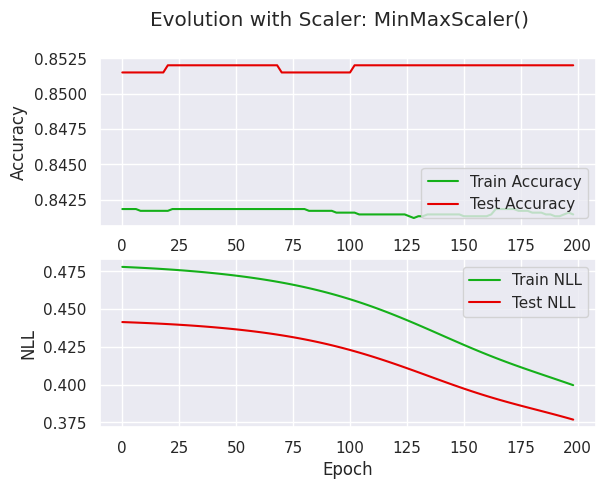

Acuratete folosind StandardScaler: 0.44849959448499593
Precision folosind StandardScaler: 0.14568081991215226
Recall folosind StandardScaler: 0.5076530612244898
F1 Score folosind StandardScaler: 0.22639362912400457


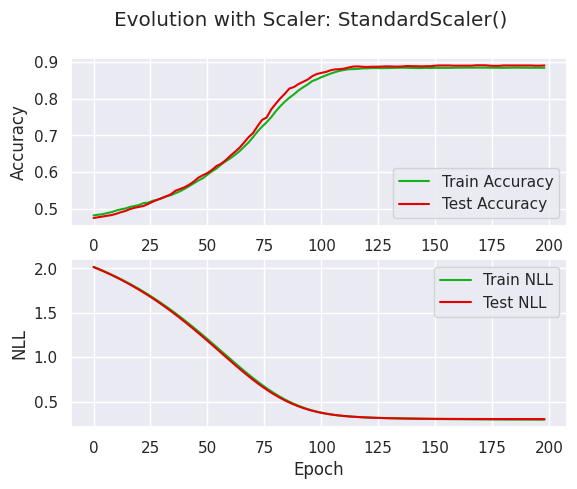

Acuratete folosind RobustScaler: 0.6184103811841039
Precision folosind RobustScaler: 0.01757469244288225
Recall folosind RobustScaler: 0.025510204081632654
F1 Score folosind RobustScaler: 0.02081165452653486


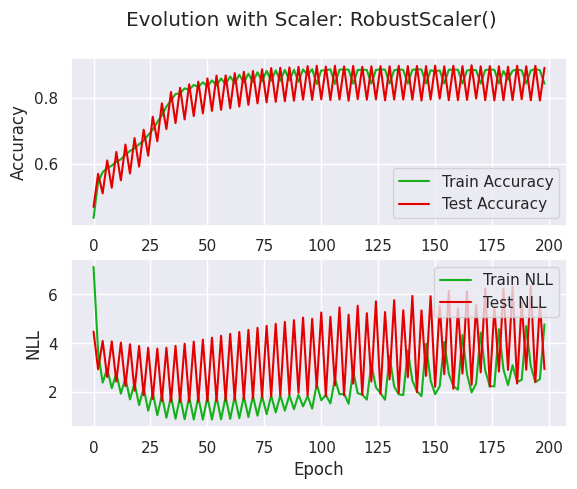


RULAREA NUMARUL 7
Acuratete folosind MinMaxScaler: 0.7814274128142741
Precision folosind MinMaxScaler: 0.05714285714285714
Recall folosind MinMaxScaler: 0.0339943342776204
F1 Score folosind MinMaxScaler: 0.04262877442273535


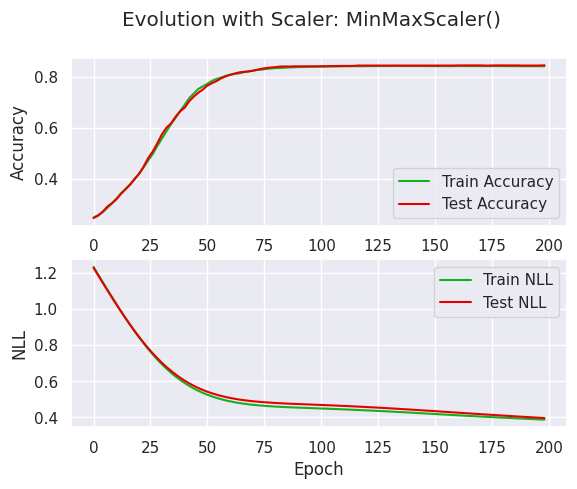

Acuratete folosind StandardScaler: 0.3442822384428224
Precision folosind StandardScaler: 0.07221458046767538
Recall folosind StandardScaler: 0.28150134048257375
F1 Score folosind StandardScaler: 0.1149425287356322


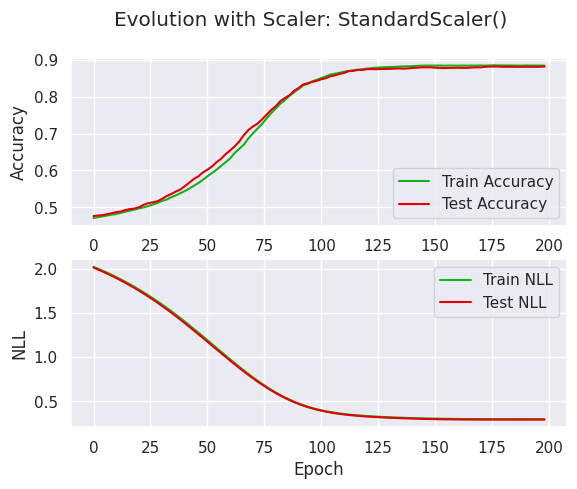

Acuratete folosind RobustScaler: 0.6553122465531225
Precision folosind RobustScaler: 0.15060240963855423
Recall folosind RobustScaler: 0.25906735751295334
F1 Score folosind RobustScaler: 0.19047619047619047


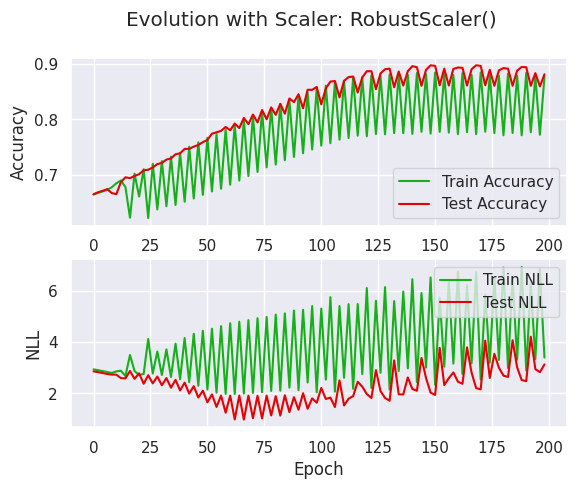


RULAREA NUMARUL 8
Acuratete folosind MinMaxScaler: 0.3236009732360097
Precision folosind MinMaxScaler: 0.0998162890385793
Recall folosind MinMaxScaler: 0.4515235457063712
F1 Score folosind MinMaxScaler: 0.1634904714142427


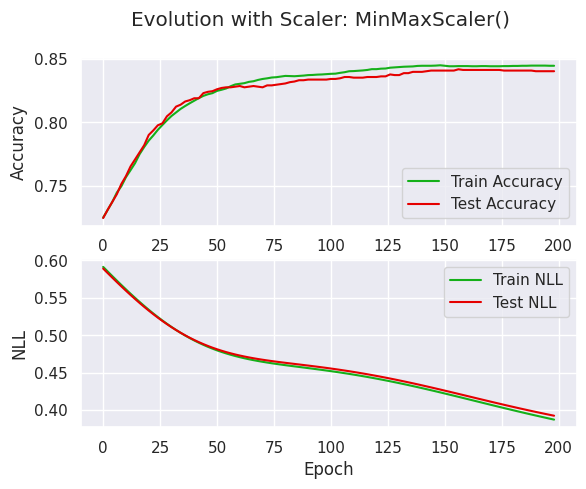

Acuratete folosind StandardScaler: 0.33454987834549876
Precision folosind StandardScaler: 0.08445040214477212
Recall folosind StandardScaler: 0.314214463840399
F1 Score folosind StandardScaler: 0.133122028526149


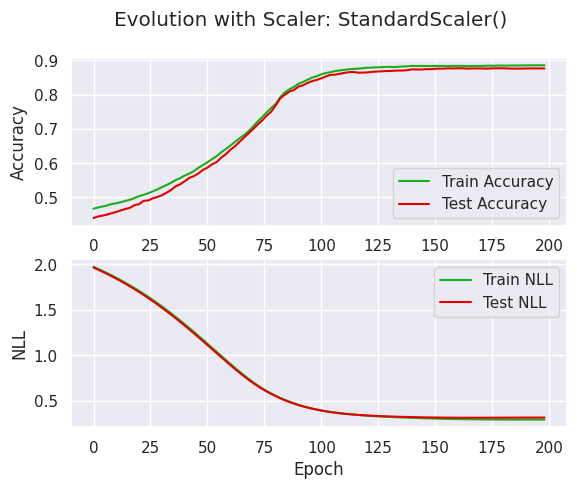

Acuratete folosind RobustScaler: 0.4829683698296837
Precision folosind RobustScaler: 0.051387461459403906
Recall folosind RobustScaler: 0.12437810945273632
F1 Score folosind RobustScaler: 0.07272727272727272


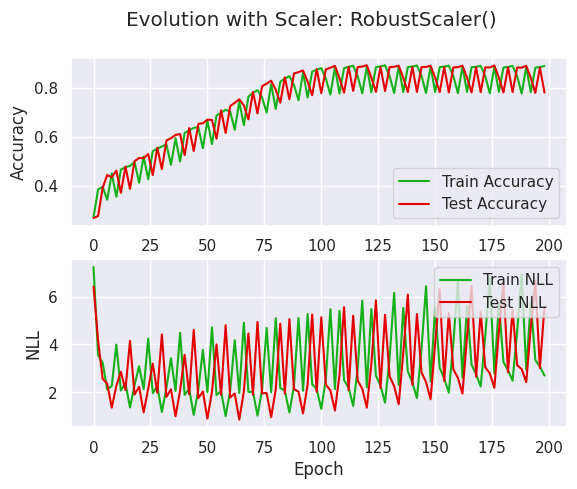


RULAREA NUMARUL 9
Acuratete folosind MinMaxScaler: 0.2526358475263585
Precision folosind MinMaxScaler: 0.12
Recall folosind MinMaxScaler: 0.6078947368421053
F1 Score folosind MinMaxScaler: 0.20043383947939264


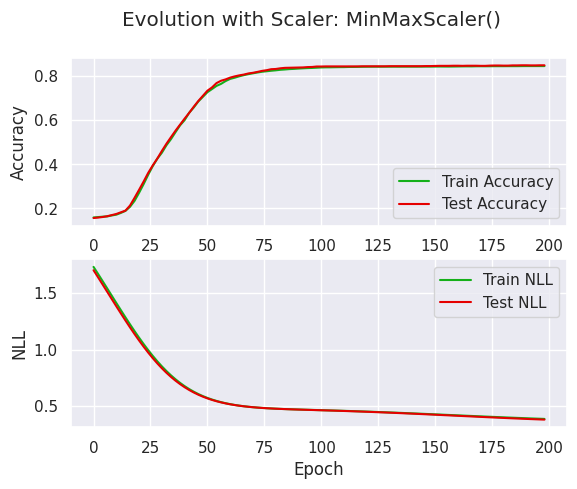

Acuratete folosind StandardScaler: 0.32725060827250607
Precision folosind StandardScaler: 0.057891109579600274
Recall folosind StandardScaler: 0.22340425531914893
F1 Score folosind StandardScaler: 0.09195402298850575


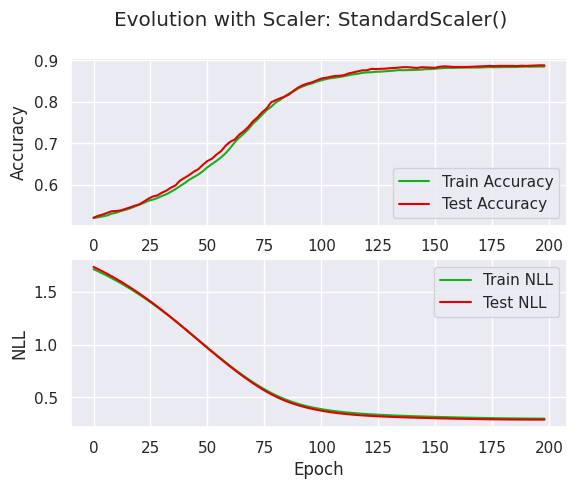

Acuratete folosind RobustScaler: 0.47526358475263586
Precision folosind RobustScaler: 0.1269199676637025
Recall folosind RobustScaler: 0.42318059299191374
F1 Score folosind RobustScaler: 0.19527363184079605


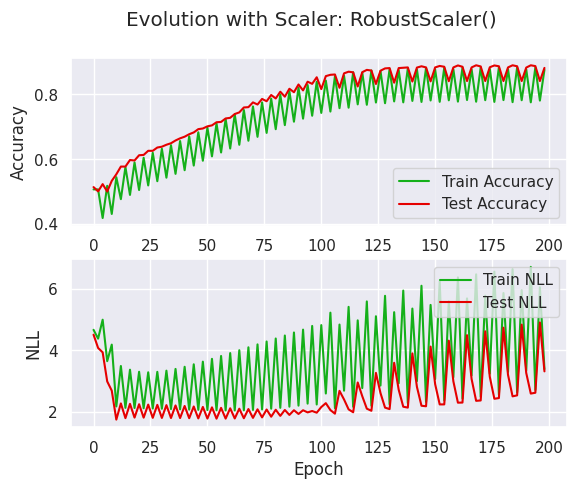


RULAREA NUMARUL 10
Acuratete folosind MinMaxScaler: 0.5961070559610706
Precision folosind MinMaxScaler: 0.06099290780141844
Recall folosind MinMaxScaler: 0.11405835543766578
F1 Score folosind MinMaxScaler: 0.07948243992606285


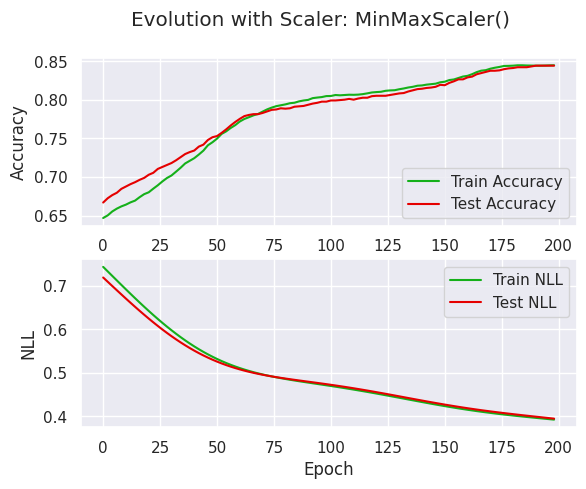

Acuratete folosind StandardScaler: 0.4018653690186537
Precision folosind StandardScaler: 0.1010752688172043
Recall folosind StandardScaler: 0.38950276243093923
F1 Score folosind StandardScaler: 0.16050085372794537


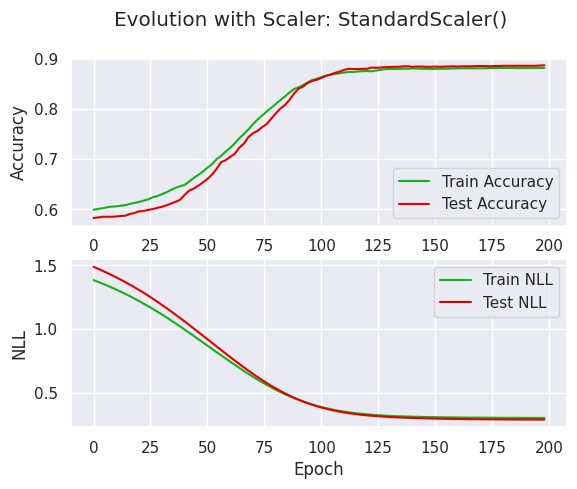

Acuratete folosind RobustScaler: 0.43714517437145173
Precision folosind RobustScaler: 0.04541406945681211
Recall folosind RobustScaler: 0.13896457765667575
F1 Score folosind RobustScaler: 0.06845637583892618


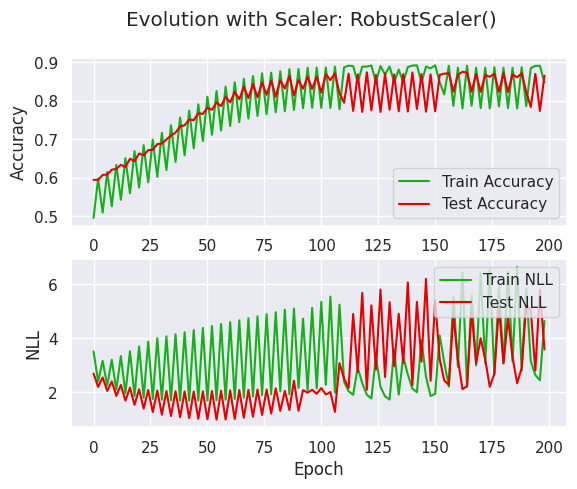


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.5452149229521492
Median Accuracy: 0.5829278183292782
Variance Accuracy: 0.0364413361538497
Min Accuracy: 0.2526358475263585
Max Accuracy: 0.813463098134631

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.3620437956204379
Median Accuracy: 0.33941605839416056
Variance Accuracy: 0.0018541474680143053
Min Accuracy: 0.32725060827250607
Max Accuracy: 0.44849959448499593

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.538037307380373
Median Accuracy: 0.5024330900243309
Variance Accuracy: 0.0066567211891949505
Min Accuracy: 0.43714517437145173
Max Accuracy: 0.6553122465531225

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.09886542793139418
Median Precision: 0.10135323122449197
Variance Precision: 0.0009843653296929913
Min Precision: 0.05714285714285714
Max Precision: 0.16683518705763398

Metrics for Precision

In [2134]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    # Preprocesarea datelor
    X, y = preprocess_data(df.copy())

    print(f"\nRULAREA NUMARUL {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_manual(X,y,lr=LR,learning_increase_percent=LEARNING_INCREASE_PERCENT,epochs_no=EPOCHS_NO,step_percent=STEP_PERCENT)
    del X, y

print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

del precision_results, recall_results, f1_score_results, accuracy_results

### 2. Implementare folosind scikit-learn

In [2135]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

# Define the scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df_shuffled.copy())

    print(f"\nRUN NUMBER {iteration + 1}")

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Scale the features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Create and train the logistic regression model
        model = LogisticRegression(random_state=None)
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Save metric values in dictionaries
        accuracy_results[f"{scaler_name}_Run_{iteration + 1}"] = accuracy
        precision_results[f"{scaler_name}_Run_{iteration + 1}"] = precision
        recall_results[f"{scaler_name}_Run_{iteration + 1}"] = recall
        f1_score_results[f"{scaler_name}_Run_{iteration + 1}"] = f1

        # Print evaluation metrics for each run and scaler
        print(f"\nMetrics for {scaler_name} - Run {iteration + 1}:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")

        # Clean up variables
        del model

    # Clean up remaining variables
    del X, y, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

# Clean up remaining variables
del precision_results, recall_results, f1_score_results, accuracy_results

Training dataset size: 12330
Number of features: 17

RUN NUMBER 1

Metrics for StandardScaler - Run 1:
Accuracy: 0.8937550689375506
Precision: 0.7918781725888325
Recall: 0.41379310344827586
F1 Score: 0.5435540069686411

Metrics for MinMaxScaler - Run 1:
Accuracy: 0.8803730738037308
Precision: 0.8203125
Recall: 0.27851458885941643
F1 Score: 0.4158415841584158

Metrics for RobustScaler - Run 1:
Accuracy: 0.894566098945661
Precision: 0.7939698492462312
Recall: 0.41909814323607425
F1 Score: 0.5486111111111112

RUN NUMBER 2


/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Metrics for StandardScaler - Run 2:
Accuracy: 0.8917274939172749
Precision: 0.782608695652174
Recall: 0.3881401617250674
F1 Score: 0.518918918918919

Metrics for MinMaxScaler - Run 2:
Accuracy: 0.8807785888077859
Precision: 0.781021897810219
Recall: 0.2884097035040431
F1 Score: 0.421259842519685

Metrics for RobustScaler - Run 2:
Accuracy: 0.8905109489051095
Precision: 0.7700534759358288
Recall: 0.3881401617250674
F1 Score: 0.5161290322580645

RUN NUMBER 3

Metrics for StandardScaler - Run 3:
Accuracy: 0.8896999188969992
Precision: 0.7429906542056075
Recall: 0.4228723404255319
F1 Score: 0.5389830508474576


/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Metrics for MinMaxScaler - Run 3:
Accuracy: 0.8819951338199513
Precision: 0.785234899328859
Recall: 0.31117021276595747
F1 Score: 0.4457142857142858

Metrics for RobustScaler - Run 3:
Accuracy: 0.889294403892944
Precision: 0.7417840375586855
Recall: 0.42021276595744683
F1 Score: 0.536502546689304

RUN NUMBER 4

Metrics for StandardScaler - Run 4:
Accuracy: 0.8848337388483374
Precision: 0.7593582887700535
Recall: 0.37270341207349084
F1 Score: 0.5000000000000001


/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Metrics for MinMaxScaler - Run 4:
Accuracy: 0.8763179237631792
Precision: 0.7714285714285715
Recall: 0.28346456692913385
F1 Score: 0.41458733205374276

Metrics for RobustScaler - Run 4:
Accuracy: 0.884022708840227
Precision: 0.7567567567567568
Recall: 0.3674540682414698
F1 Score: 0.4946996466431096

RUN NUMBER 5

Metrics for StandardScaler - Run 5:
Accuracy: 0.8876723438767234
Precision: 0.7865168539325843
Recall: 0.36939313984168864
F1 Score: 0.5026929982046678

Metrics for MinMaxScaler - Run 5:
Accuracy: 0.8763179237631792
Precision: 0.7846153846153846
Recall: 0.2691292875989446
F1 Score: 0.400785854616896

Metrics for RobustScaler - Run 5:
Accuracy: 0.8876723438767234
Precision: 0.7865168539325843
Recall: 0.36939313984168864
F1 Score: 0.5026929982046678

RUN NUMBER 6

Metrics for StandardScaler - Run 6:
Accuracy: 0.884022708840227
Precision: 0.734375
Recall: 0.375
F1 Score: 0.4964788732394366

Metrics for MinMaxScaler - Run 6:
Accuracy: 0.8799675587996756
Precision: 0.7898550724637

/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Metrics for RobustScaler - Run 6:
Accuracy: 0.884022708840227
Precision: 0.7319587628865979
Recall: 0.3776595744680851
F1 Score: 0.4982456140350877

RUN NUMBER 7

Metrics for StandardScaler - Run 7:
Accuracy: 0.894566098945661
Precision: 0.797979797979798
Recall: 0.41798941798941797
F1 Score: 0.5486111111111112

Metrics for MinMaxScaler - Run 7:
Accuracy: 0.8832116788321168
Precision: 0.7960526315789473
Recall: 0.3201058201058201
F1 Score: 0.4566037735849057

Metrics for RobustScaler - Run 7:
Accuracy: 0.8925385239253852
Precision: 0.7897435897435897
Recall: 0.4074074074074074
F1 Score: 0.537521815008726

RUN NUMBER 8

Metrics for StandardScaler - Run 8:
Accuracy: 0.8961881589618816
Precision: 0.7354497354497355
Recall: 0.4028985507246377
F1 Score: 0.5205992509363295

Metrics for MinMaxScaler - Run 8:
Accuracy: 0.8876723438767234
Precision: 0.765625
Recall: 0.28405797101449276
F1 Score: 0.41437632135306557


/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Metrics for RobustScaler - Run 8:
Accuracy: 0.8941605839416058
Precision: 0.7210526315789474
Recall: 0.39710144927536234
F1 Score: 0.5121495327102804

RUN NUMBER 9

Metrics for StandardScaler - Run 9:
Accuracy: 0.8929440389294404
Precision: 0.7037037037037037
Recall: 0.39002932551319647
F1 Score: 0.5018867924528301

Metrics for MinMaxScaler - Run 9:
Accuracy: 0.8844282238442822
Precision: 0.7089552238805971
Recall: 0.2785923753665689
F1 Score: 0.39999999999999997

Metrics for RobustScaler - Run 9:
Accuracy: 0.8933495539334956
Precision: 0.7074468085106383
Recall: 0.39002932551319647
F1 Score: 0.5028355387523629

RUN NUMBER 10


/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Metrics for StandardScaler - Run 10:
Accuracy: 0.8832116788321168
Precision: 0.7611111111111111
Recall: 0.3586387434554974
F1 Score: 0.4875444839857651

Metrics for MinMaxScaler - Run 10:
Accuracy: 0.8763179237631792
Precision: 0.8290598290598291
Recall: 0.25392670157068065
F1 Score: 0.3887775551102205

Metrics for RobustScaler - Run 10:
Accuracy: 0.8844282238442822
Precision: 0.770949720670391
Recall: 0.3612565445026178
F1 Score: 0.4919786096256684

FINAL STATISTICS

ACCURACY

Metrics for Accuracy with StandardScaler_Run_1 after 10 runs:
Mean Accuracy: 0.8937550689375506
Median Accuracy: 0.8937550689375506
Variance Accuracy: 0.0
Min Accuracy: 0.8937550689375506
Max Accuracy: 0.8937550689375506

Metrics for Accuracy with MinMaxScaler_Run_1 after 10 runs:
Mean Accuracy: 0.8803730738037308
Median Accuracy: 0.8803730738037308
Variance Accuracy: 0.0
Min Accuracy: 0.8803730738037308
Max Accuracy: 0.8803730738037308

Metrics for Accuracy with RobustScaler_Run_1 after 10 runs:
Mean Accuracy:

/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3.2.2. Arbore de Decizie

### 1. Implementare folosind scikit-learn

### 2. Implementare manuală